In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from skimage import io
from skimage.color import rgb2gray
from skimage import exposure
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.morphology import closing
from skimage.morphology import square as squared
from skimage.segmentation import clear_border
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage import morphology,feature,measure,filters,color


%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

Populating the interactive namespace from numpy and matplotlib


# Load the individual images and stitch them together

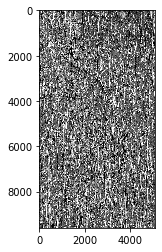

In [2]:
DIR = os.path.join(os.getcwd(), 'SEM-images')
nws_row1 = np.concatenate((io.imread(os.path.join(DIR, '10001.tif')), io.imread(os.path.join(DIR, '10002.tif'))), axis=1)
nws_row2 = np.concatenate((io.imread(os.path.join(DIR, '10003.tif')), io.imread(os.path.join(DIR, '10004.tif'))), axis=1)
nws_row3 = np.concatenate((io.imread(os.path.join(DIR, '10005.tif')), io.imread(os.path.join(DIR, '10006.tif'))), axis=1)
nws_row4 = np.concatenate((io.imread(os.path.join(DIR, '10007.tif')), io.imread(os.path.join(DIR, '10008.tif'))), axis=1)
nws_row5 = np.concatenate((io.imread(os.path.join(DIR, '10009.tif')), io.imread(os.path.join(DIR, '10010.tif'))), axis=1)
nws = np.concatenate((nws_row1, nws_row2, nws_row3, nws_row4, nws_row5), axis=0)
plt.imshow(nws, cmap='gray')

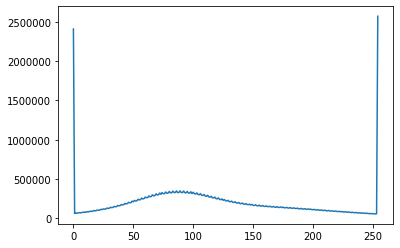

In [3]:
histo = np.histogram(nws, bins=np.arange(256))
plt.plot(histo[1][:-1], histo[0])

# Threshold-based segmentation

threshold = 132


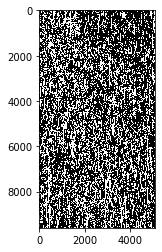

In [4]:
thresh = threshold_otsu(nws)
#thresh = 150
print('threshold = %d' % thresh)

nws_thresh = nws
mask_light = nws > thresh
nws_thresh[mask_light] = 255
mask_dark = nws < thresh
nws_thresh[mask_dark] = 0
plt.imshow(nws_thresh, cmap="gray")

In [5]:
s = ndi.generate_binary_structure(2,2)
print(s)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [18]:
#s = ndi.generate_binary_structure(2,2)   
s = [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]]   # 8近邻模式
label_objects, nb_labels = ndi.label(nws_thresh, structure=s)   #nws_thresh是阈值过滤后的图像
print('>> label_object:',label_objects)  #被标记的矩阵
print('>> b_labels:',nb_labels)  #标记的个数
sizes = np.bincount(label_objects.ravel())
print('>> sizes:',sizes)
mask_sizes = sizes > 200  #大于200个像素点的集团
print('>> mask_sizes:',mask_sizes)
mask_sizes[0] = 0  #去掉200个像素点的集团
print('>> mask_sizes:',mask_sizes)  
nws_thresh_cleaned = mask_sizes[label_objects]  #去掉面积小于等于200的集团
print('>> nws_thresh_cleaned:',nws_thresh_cleaned)

>> label_object: [[     1      1      1 ...      0      0      0]
 [     1      1      1 ...      0      0      0]
 [     1      1      1 ...      0      0      0]
 ...
 [     0      0      0 ... 841599 841599 841599]
 [     0      0      0 ... 841599 841599 841599]
 [     0      0      0 ... 841599 841599 841599]]
>> b_labels: 842726
>> sizes: [31902495  5421914        2 ...        1        1        1]
>> mask_sizes: [ True  True False ... False False False]
>> mask_sizes: [False  True False ... False False False]
>> nws_thresh_cleaned: [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


numpy.ndarray

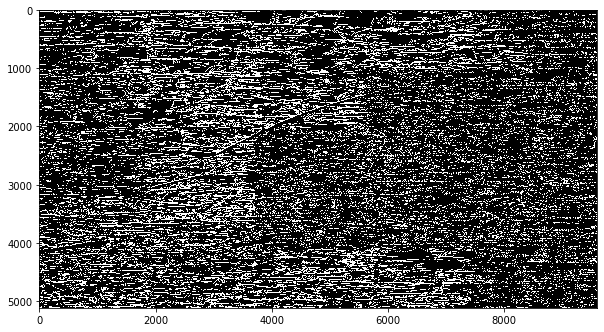

In [19]:
plt.figure(figsize=(10,8))
plt.imshow(ndi.rotate(nws_thresh_cleaned,90), cmap="gray")

<font color=Chocolate size=4> Display different colors according to different tags</font>

regions number: 2273


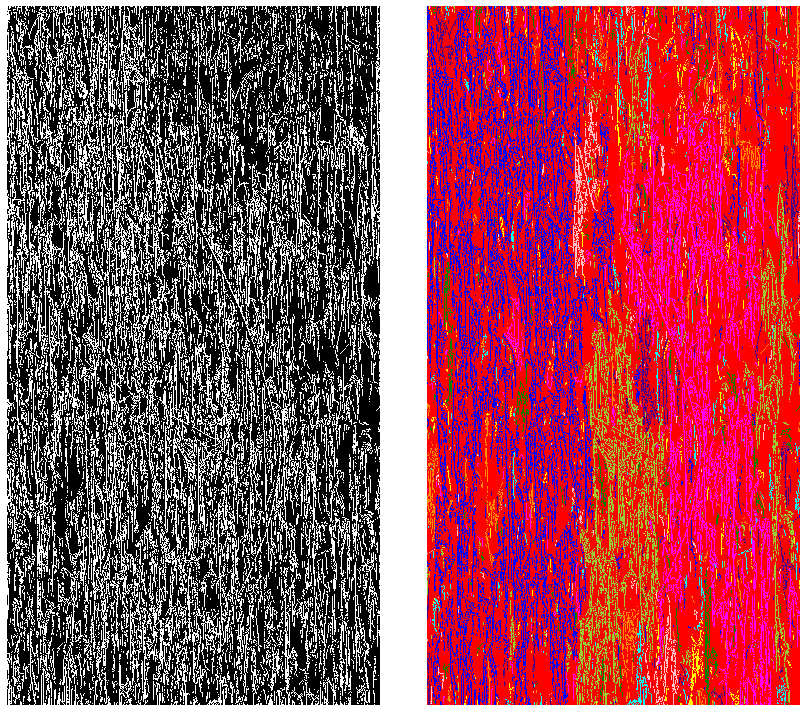

In [34]:
label_objects_1, nb_labels_1 = ndi.label(nws_thresh_cleaned, structure=s)  #再次标记 Label again(>200)
dst=color.label2rgb(label_objects_1)  #根据不同的标记显示不同的颜色 Display different colors according to different tags
print('regions number:',label_objects_1.max()+1)  #显示连通区域块数(从0开始标记) Display the number of connected area blocks (marked from 0)
label_objects_2 = mask_sizes[label_objects]  # 将灰度图像转换为二值图 Converting gray image to binary image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(label_objects_2, plt.cm.gray)
ax1.axis('off')
ax2.imshow(dst,interpolation='nearest')
ax2.axis('off')
 
fig.tight_layout()

plt.show()

In [55]:
#返回所有连通区块的属性列表 Returns a list of attributes for all connected blocks
from skimage.measure import regionprops
prop = regionprops(np.array(label_objects_1).astype(int))
print(type(prop))
print('centroid:',prop[1].centroid,'\n',
      'area:',prop[1].area,'\n',
      'perimeter:',prop[1].perimeter,'\n'
      'bbox:',prop[1].bbox,'\n')
shape(prop)

<class 'list'>
centroid: (19.76984126984127, 36.08201058201058) 
 area: 378 
 perimeter: 145.19595949289334 
bbox: (0, 30, 41, 43) 



(2272,)

<font color=Chocolate size=4> Draw 3 large areas marked by labels 1-red 383-green 769-blue</font>

In [85]:
# 找到面积最大的几个区域 Find the largest areas
valid_label = set()
for p in prop:
    if p.area > 300000:
        valid_label.add(p.label)
        print('label:',p.label,'\tarea:',p.area,'\tperimeter:',p.perimeter)

label: 1 	area: 5421914 	perimeter: 1982372.1967303543
label: 383 	area: 2509468 	perimeter: 899190.5467125172
label: 769 	area: 313945 	perimeter: 110181.45262953444
label: 1039 	area: 1318259 	perimeter: 495551.4006734092


In [11]:
height,width = nws_thresh_cleaned.shape # 图片尺寸 picture size

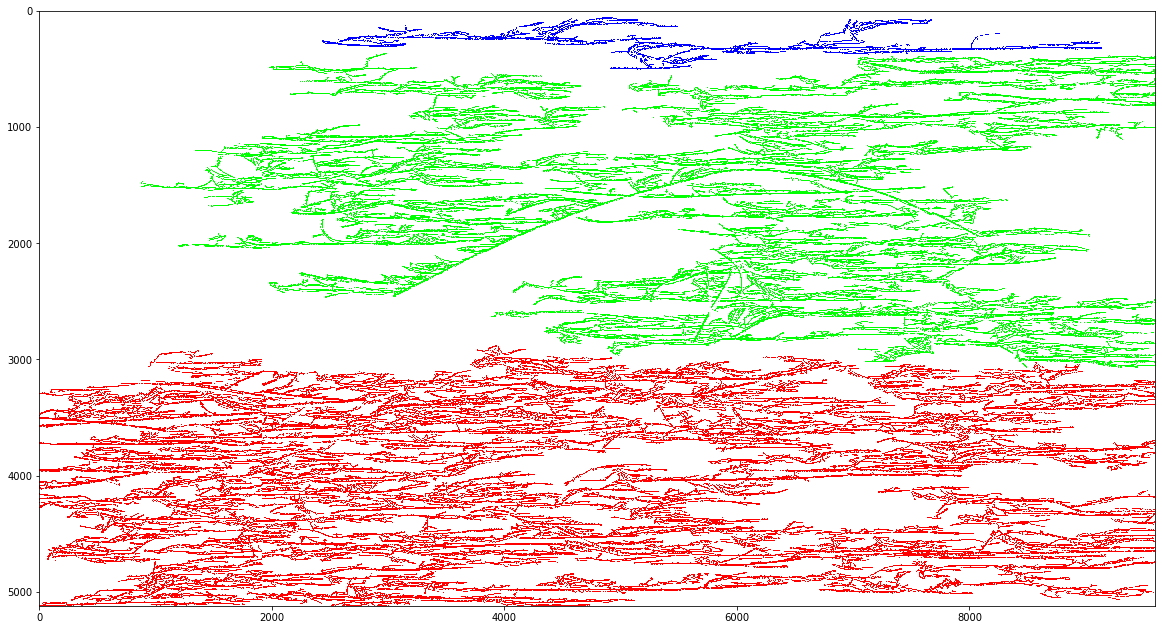

In [79]:
nws_thresh_cleaned_marked_1 = np.array([[[0,0,0]]*width]*height) # 空白数组用来画图 Blank array for drawing
for m in range(len(label_objects_1)):
    for n in range(len(label_objects_1[m])):
        if label_objects_1[m,n]==1 :
               nws_thresh_cleaned_marked_1[m,n] = [1.,0.,0.] # Label 1 in red
        elif label_objects_1[m,n]==383 :
               nws_thresh_cleaned_marked_1[m,n] = [0.,1.,0.] # Label 383 in green
        elif label_objects_1[m,n]==769 :
               nws_thresh_cleaned_marked_1[m,n] = [0.,0.,1.] # Label 769 in blue
        else:
               nws_thresh_cleaned_marked_1[m,n] = [1.,1.,1.]
plt.figure(figsize=(20,18))
plt.imshow(double(ndi.rotate(nws_thresh_cleaned_marked_1,90)))    

In [53]:
np.set_printoptions(threshold=100) # 这个参数填的是你想要多少行显示
np.set_printoptions(linewidth=100) # 这个参数填的是横向多宽
print('>> mask_sizes:',mask_sizes[4])

>> mask_sizes: True


In [147]:
#image size: 9600*5120
nws_thresh_cleaned_marked = np.array([[[0,0,0]]*width]*height)
for i in range(len(nws_thresh_cleaned)):
    for k in range(len(nws_thresh_cleaned[i])):
        if nws_thresh_cleaned[i,k]==1:
            nws_thresh_cleaned_marked[i,k] = [1.,0.,0.]
        else:
            nws_thresh_cleaned_marked[i,k] = [1.,1.,1.]
plt.figure(figsize=(18,14))
plt.imshow(double(ndi.rotate(nws_thresh_cleaned_marked,90)))       

# Region-based segmentation

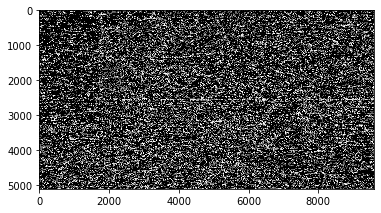

In [38]:
from skimage.filters import sobel
elevation_map = sobel(nws)  # this is edgs 这是边缘
plt.imshow(ndi.rotate(elevation_map, 90), cmap="gray")

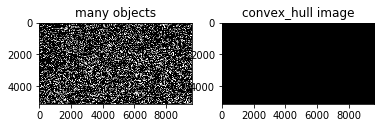

In [39]:
#edgs=feature.canny(nws)#, sigma=.1)#,low_threshold=0, high_threshold=255) 
edgs = elevation_map
chull = morphology.convex_hull_object(edgs)

#绘制轮廓 Draw outline
fig, axes = plt.subplots(1,2)
ax0, ax1= axes.ravel()
ax0.imshow(ndi.rotate(edgs,90),plt.cm.gray)
ax0.set_title('many objects')
ax1.imshow(ndi.rotate(chull,90),plt.cm.gray)
ax1.set_title('convex_hull image')
plt.show()

In [40]:
#检测所有图形的轮廓 Detecting contours of all graphics
contours = measure.find_contours(nws, 0.5)

#绘制轮廓  Draw outline
fig, axes = plt.subplots(1,2) #,figsize=(8,8))
ax0, ax1= axes.ravel()
ax0.imshow(nws,plt.cm.gray)
ax0.set_title('original image')

rows,cols=nws.shape
ax1.axis([0,rows,cols,0])
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax1.axis('image')
ax1.set_title('contours')
plt.show()

KeyboardInterrupt: 

<font color=Chocolate size=3> name 'markers' is not defined </font>

<font color=gray>from skimage.morphology import watershed<br> 
  segmentation = watershed(elevation_map, markers)<br> 
  plt.imshow(segmentation, cmap="gray")<br> </font>


# Distance-based watershed segmentation

In [41]:
distance = ndi.distance_transform_edt(nws) #距离变换 Range conversion
local_maxi =feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),labels=nws) #寻找峰值 Search for peak value
markers = ndi.label(local_maxi)[0] #初始标记点 Initial marker points
labels =morphology.watershed(-distance, markers, mask=nws) #基于距离变换的分水岭算法 Watershed algorithm based on distance transformation

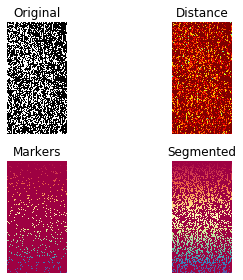

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2)  #figsize=(8, 8)
axes = axes.ravel()
ax0, ax1, ax2, ax3 = axes

ax0.imshow(nws, cmap=plt.cm.gray, interpolation='nearest')
ax0.set_title("Original")
ax1.imshow(-distance, cmap=plt.cm.jet, interpolation='nearest')
ax1.set_title("Distance")
ax2.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax2.set_title("Markers")
ax3.imshow(labels, cmap="Spectral", interpolation='nearest')
ax3.set_title("Segmented")

for ax in axes:
    ax.axis('off')

fig.tight_layout()
plt.show()

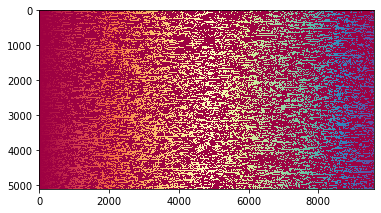

In [43]:
plt.imshow(ndi.rotate(labels,90),cmap="Spectral",interpolation='nearest') #放大 Zoom in

<font color=Chocolate size=3> name 'segmentation' is not defined </font>

<font color=gray> s = ndi.generate_binary_structure(2,2)<br>
label_objects, nb_labels = ndi.label(segmentation-1, structure = s)<br>
sizes = np.bincount(label_objects.ravel())<br>
mask_sizes = sizes > 200<br>
mask_sizes[0] = 0<br>
nws_segmented_cleaned = mask_sizes[label_objects]<br>
plt.imshow(nws_segmented_cleaned, cmap="gray")</font>

# Gradient-based watershed segmentation

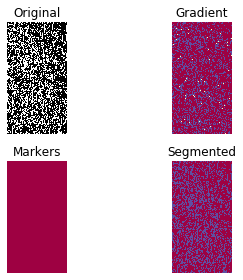

In [44]:
denoised = filters.rank.median(nws, morphology.disk(2)) #过滤噪声 Filtering noise

#将梯度值低于5的作为开始标记点 Use gradient less than 5 as the starting marker
markers = filters.rank.gradient(denoised, morphology.disk(5)) <5 #可以尝试更多的值 We can try more values.
markers = ndi.label(markers)[0]

gradient = filters.rank.gradient(denoised, morphology.disk(2)) #计算梯度 Computational gradient
labels =morphology.watershed(gradient, markers, mask=nws) #基于梯度的分水岭算法 Gradient-based watershed algorithm

fig, axes = plt.subplots(nrows=2, ncols=2)  #, figsize=(6, 6)
axes = axes.ravel()
ax0, ax1, ax2, ax3 = axes

ax0.imshow(nws, cmap=plt.cm.gray, interpolation='nearest')
ax0.set_title("Original")
ax1.imshow(gradient, cmap=plt.cm.Spectral, interpolation='nearest')
ax1.set_title("Gradient")
ax2.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax2.set_title("Markers")
ax3.imshow(labels, cmap=plt.cm.Spectral, interpolation='nearest')
ax3.set_title("Segmented")

for ax in axes:
    ax.axis('off')

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Markers')

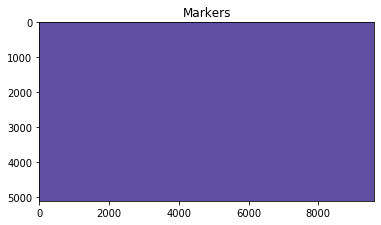

In [45]:
plt.imshow(ndi.rotate(markers,90), cmap=plt.cm.Spectral, interpolation='nearest')
plt.title("Markers")

In [ ]:
plt.imshow(ndi.rotate(labels,90), cmap=plt.cm.Spectral, interpolation='nearest')
plt.title('Segmented')

# fdfdfdf

In [ ]:
H = 15.9 # Height of each image in microns
W = 21.2 # Width of each image in microns
pic1 = io.imread(os.path.join(DIR, '10001.tif'))
dx = W/float(np.shape(pic1)[1]) # Width of each pixel in microns
dy = H/float(np.shape(pic1)[0]) # Height of each pixel in microns

In [ ]:
print(dx)
print(dy)


In [ ]:
def makeElectrodes(w, l, s):
    """
    """
    canvas = np.zeros((2*l+s, w))
    canvas[0:l, :] = 1
    canvas[l+s:, :] = 1
    return img_as_ubyte(canvas)

In [ ]:
def trial(image, w, l, s):
    """
    """
    x = randint(0, shape(nws)[1]-w, dtype='int')
    print('x = ' + str(x))
    y = randint(0, shape(nws)[0]-(2*l+s), dtype='int')
    print('y = ' + str(y))
    electrodes = makeElectrodes(w, l, s)
    temp_image = img_as_ubyte(image)
    temp_image[y:y+2*l+s, x:x+w] += electrodes 
   # image = image/2
    return img_as_ubyte(temp_image), x, y

In [ ]:
A = np.zeros((np.size(nws_thresh_cleaned, 0), np.size(nws_thresh_cleaned, 1)))
A, x, y = trial(nws_thresh_cleaned, 500, 100, 500)
plt.imshow(A[y:y+700, x:x+500], cmap='gray')

In [ ]:
labels = label(A, connectivity=2)
labels[y:y+700, x:x+500]

In [ ]:
labels[y+1, x+1]

In [ ]:
labels[y+3, x+2]

In [ ]:
mask_dev = labels == labels[y, x]
print(mask_dev[y-1:y+101, x-1:x+501])

In [ ]:
plt.imshow(mask_dev, cmap='gray')

In [ ]:
labeled_final = label(mask_dev)

In [ ]:
labeled_final_overlay = label2rgb(labeled_final, image=A)

In [ ]:
plt.imshow(labeled_final_overlay)

In [ ]:
labeled_final_overlay

In [4]:
for region in regionprops(labeled_final):
    print(region.area)

NameError: name 'labeled_final' is not defined